In [1]:
include("../../juliasrc/calculate_potentials.jl");

 Activating environment at `~/HDD/PROJECTS/local-bpm-e34/Project.toml`
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


In [2]:
function mse(a::MinimizationTarget, b::MinimizationTarget)
    currents =  mean(@. (a.currents - b.currents)^2)
    return exp(1e5*(a.std_x - b.std_x)^2) - 1 + exp(1e5*(a.std_y - b.std_y)^2) -1 + currents
end


mse (generic function with 2 methods)

In [3]:
using Images
using ImageQualityIndexes

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260


In [4]:
function get_ssim_error(x,y)
    a = fit(Histogram, (x[:,1], x[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    b = fit(Histogram, (y[:,1], y[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    # return mean((a.weights  - b.weights ).^2)
    assess_ssim(a.weights./maximum(a.weights), b.weights./maximum(b.weights))
end

get_ssim_error (generic function with 1 method)

In [5]:
function get_pixel_error(x, y)
    a = fit(Histogram, (x[:,1], x[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    b = fit(Histogram, (y[:,1], y[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    return mean((a.weights  - b.weights ).^2)
end

get_pixel_error (generic function with 1 method)

In [6]:
std_noise_levels = [0, 10, 20, 30];

In [7]:
using CSV, DataFrames, Glob

In [12]:
test_samples = [convert(Matrix,CSV.read(filename, header=false)) for filename in glob("2020.05.29 data/testsamples/*.csv")];

In [8]:
std_noised = [[convert(Matrix,CSV.read(filename, header=false)) for filename in glob("2020.05.29 data/std_noise/$i/*.csv")] for i in std_noise_levels];

In [13]:
std_noised_errors = [[get_ssim_error(std_noised[j][i], test_samples[i]) for i in eachindex(test_samples)] for j in eachindex(std_noised)];

# Noise on the <x^2> and <y^2>

In [14]:
using LaTeXStrings

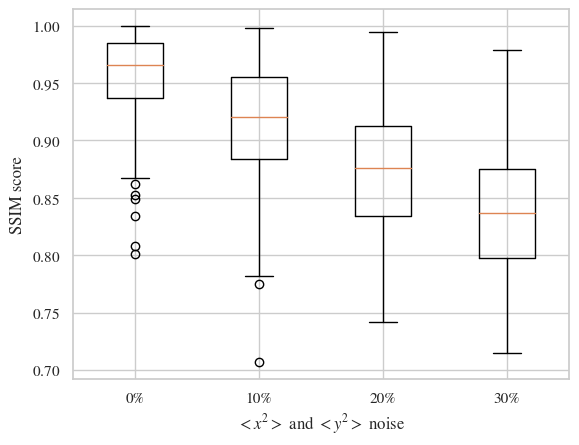

In [16]:
boxplot(std_noised_errors)
xticks([1, 2, 3, 4], ["0%", "10%", "20%", "30%"])
xlabel(L"$<x^2>$ and $<y^2>$ noise")
ylabel("SSIM score")
savefig("2020.05.29 paper_plots/ssim_vs_noise500.png", dpi=500)

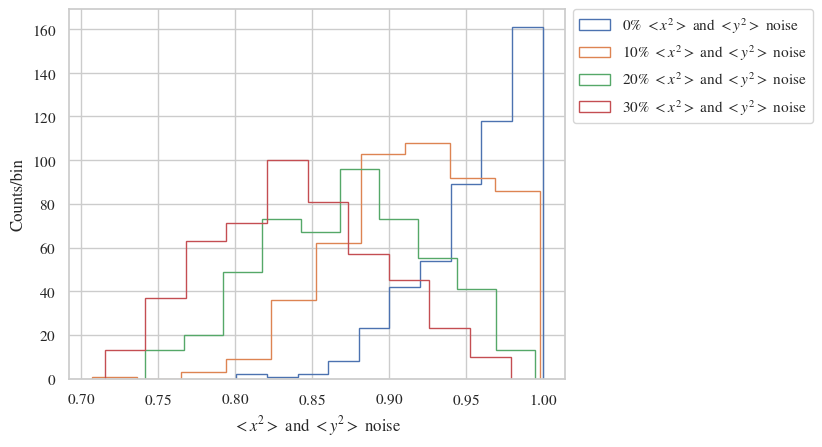

PyObject <matplotlib.legend.Legend object at 0x7f3f02a87430>

In [27]:
hist(std_noised_errors[1], histtype="step", label=L"0% $<x^2>$ and $<y^2>$ noise")
hist(std_noised_errors[2], histtype="step", label=L"10% $<x^2>$ and $<y^2>$ noise")
hist(std_noised_errors[3], histtype="step", label=L"20% $<x^2>$ and $<y^2>$ noise")
hist(std_noised_errors[4], histtype="step", label=L"30% $<x^2>$ and $<y^2>$ noise")
# xticks([1, 2, 3, 4], ["0%", "10%", "20%", "30%"])
xlabel(L"$<x^2>$ and $<y^2>$ noise")
ylabel("Counts/bin")
legend(bbox_to_anchor=(1., 1.02))

In [21]:
plotting_indices = [4, 26, 24, 50, 20]

5-element Array{Int64,1}:
  4
 26
 24
 50
 20

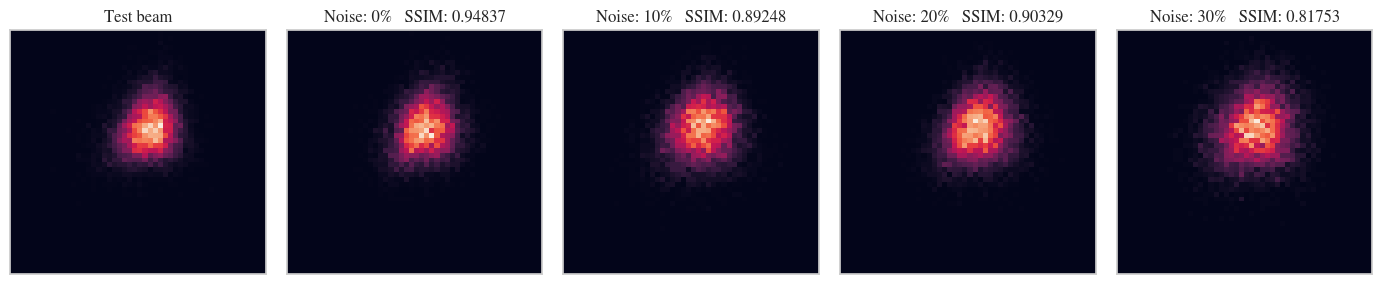

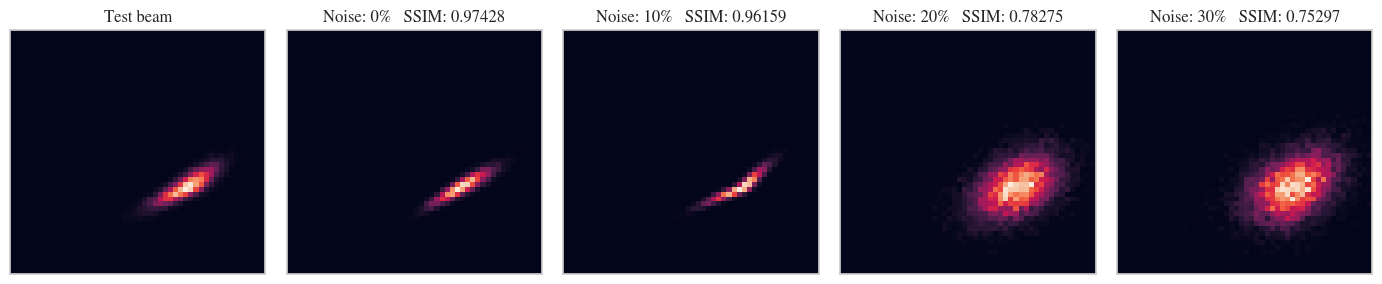

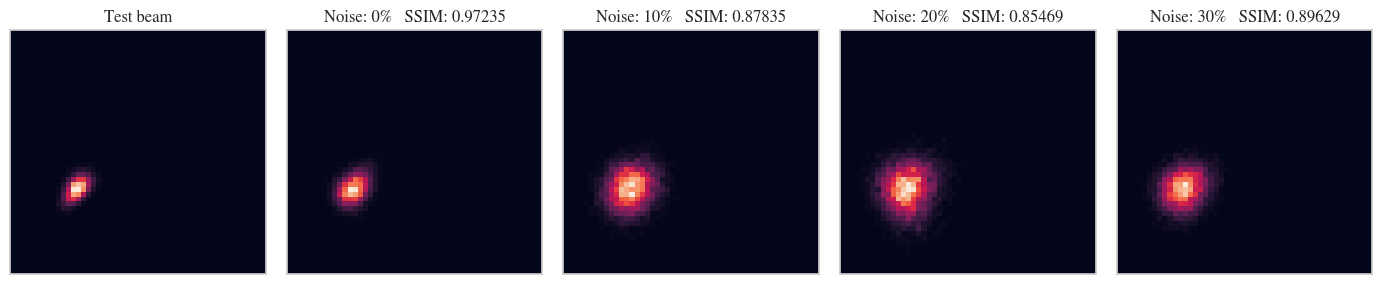

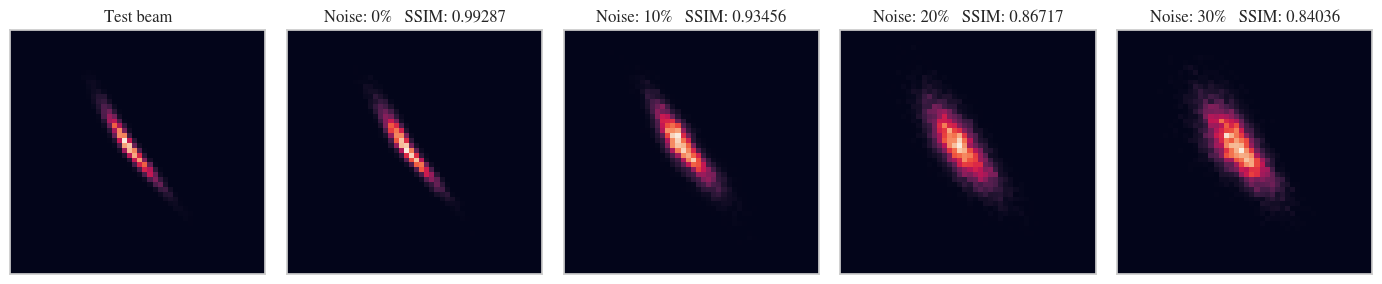

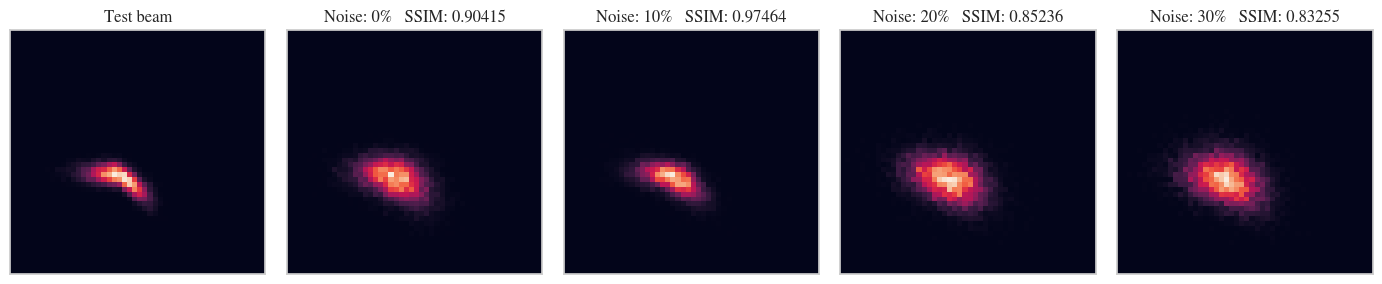

In [32]:
for i in eachindex(test_samples[1:50])
    if !(i in plotting_indices)
        continue
    end
    noofplots = 5 
    
    fig, axes = plt.subplots(nrows=1, ncols=noofplots, sharey=true,figsize=(noofplots*2.8, 3))

    edges = range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)

    sca(axes[1])
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_ticklabels([])
    
    Z, xedges, yedges = hist2D(test_samples[i][:,2], test_samples[i][:,1], bins=[edges, edges])
    plt.pcolormesh(edges, edges, Z)
    # plt.colorbar()
    # xlabel("x [m]")
    # ylabel("y [m]")
    title("Test beam")
    for j in 2:noofplots
        sca(axes[j])
        axes[j].xaxis.set_ticklabels([])
        axes[j].yaxis.set_ticklabels([])

        y = std_noised[j-1][i]
        error = get_ssim_error(test_samples[i], y)

        Z, xedges, yedges = hist2D(y[:,2], y[:,1], bins=[edges, edges])
        plt.pcolormesh(edges, edges, Z)
        # plt.colorbar()
        title("Noise: $(std_noise_levels[j-1])%   SSIM: $(round(error, sigdigits=5))")
        # xlabel("x [m]")

    end
    tight_layout()
    savefig("2020.05.29 paper_plots/$(i).png", dpi=500)
    
end

In [36]:
test_samples

50-element Array{Array{Float64,2},1}:
 [-0.0041343398945560186 0.004334976608506321; -0.004231908947941602 0.004656635084373215; … ; 0.0008831798998103801 0.006252783494159184; -0.009704514656885046 0.0019905563277890525]
 [0.009955607654741083 0.0031487253081439854; 0.011225827999583743 -0.0033468978224615977; … ; 0.009585682001095538 0.00328331650577042; 0.009183247415870604 0.002839122029330185]
 [0.0013407512145659308 0.005612452812601367; -0.009531063890235662 0.0016569496492771225; … ; -0.010251301666140829 0.0009559813468486656; -0.0036374582060867146 -0.0014993341594044247]
 [0.004628578896533016 0.001025216861689509; 0.002214720111931009 0.0019603222193308118; … ; -0.001803545117064543 0.0019223012032098898; 0.0018249289553549013 0.003019817043844183]
 [-0.0019697446403804083 0.00027678079919728785; -0.008805298435235158 0.003375847235606486; … ; -0.009137784405753267 0.003281855700432236; -0.0013805716507117062 -0.0026978047044315845]
 [0.00554476290370694 0.00281994105315228

In [38]:
get_random_distorted_gaussian_beam()

10000×2 Array{Float64,2}:
 -0.00108686   -0.00479927
  0.00355821   -0.00249298
  0.0121679     0.000582866
 -0.00853237    0.0024757
  0.00229156   -0.00459508
  0.00485757   -0.000448762
  0.00542053   -0.00177315
  0.0047289     4.32435e-6
  0.000793104   0.000648259
  0.001555      0.00239071
  0.00239282    0.00258055
  0.000103197  -0.00174481
  0.00203948   -0.00302501
  ⋮            
  0.00535976    0.000166151
  0.00175952   -0.00367798
 -0.0011366     0.00108697
 -0.00180683    0.00147544
  0.00640155   -0.00264709
  0.0033382     0.00393723
  0.00371192   -0.000425319
  0.00992609    0.00160148
  0.00497788    0.00208068
  0.00829215    0.00735342
  0.00835548   -0.00395169
  0.0025296    -0.00148103

In [42]:
get_current_at_probes(test_samples[1])

8-element Array{Float64,1}:
 1.479978721045736
 1.61706367834029
 1.2165688603583957
 0.8224323547227028
 0.6087873909445938
 0.5658392700894194
 0.6678136415658701
 0.9726376959693539

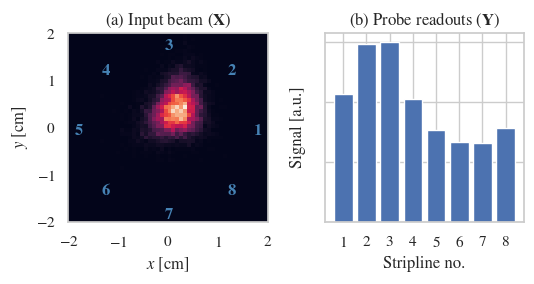

In [89]:
i = 4
x = 1e2 .* test_samples[i]

y = get_current_at_probes(x ./ 1e2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5.5,3))

edges = 1e2 .* range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)

sca(axes[1])
#axes[1].xaxis.set_ticklabels([])
#axes[1].yaxis.set_ticklabels([])

xlabel(raw"$x$ [cm]")
ylabel(raw"$y$ [cm]")


Z, xedges, yedges = hist2D(x[:,2], x[:,1], bins=[edges, edges])
plt.pcolormesh(edges, edges, Z)
radius = 2
offset = 0.2
for (i,angle) in enumerate(probe_angles)
    angle +=  0 * pi/2
    axes[1].annotate("$(i)",
                #xy=(radius*100*np.cos(angle), radius*100*np.sin(angle)),
                xy=(-0.07 + (radius-offset)*cos(angle), - 0.15 + (radius-offset)*sin(angle)),
                # ha="center",
                # va="center",
                color="steelblue",
                weight="bold") # , xycoords="axes fraction")

end
    # plt.colorbar()
    # xlabel("x [m]")
    # ylabel("y [m]")
# axes[1].tick_params(which="both", bottom=true, left=true, direction="out", length=6, width=1, grid_alpha=0.5)
# tick_params(which="both", bottom=True)
title(raw"(a) Input beam ($\mathbf{X}$)")

sca(axes[2])
# axes[2].xaxis.set_ticklabels([])
axes[2].yaxis.set_ticklabels([])
ylabel("Signal [a.u.]")


bar(collect(1:8), y)
axes[2].set_xticks(collect(1:8))
axes[2].set_xlabel("Stripline no.")
title(raw"(b) Probe readouts ($\mathbf{Y}$)")

tight_layout()
savefig("2020.05.29 paper_plots/transform.png", dpi=500)

show()

In [16]:
fig

Figure(PyObject <Figure size 60000x30000 with 2 Axes>)